## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def poly(a,b,c,x):
    return a*(x-b)**2+c

def min_poly(a,b,c):
    return np.sum(c)

In [3]:
# Generate Training Data
n_train = 100
n_hidden = 20

a_train = np.random.uniform(size=(n_train,1),low = 0.5, high = 5.0)
b_train = np.random.uniform(size=(n_train,1),low = -3.0, high = 3.0)
c_train = np.random.uniform(size=(n_train,1),low = -2.0, high = 2.0)

x_init = np.zeros((n_train,1))
h_init = np.zeros((n_train,n_hidden))

## Visualize Training Distribution

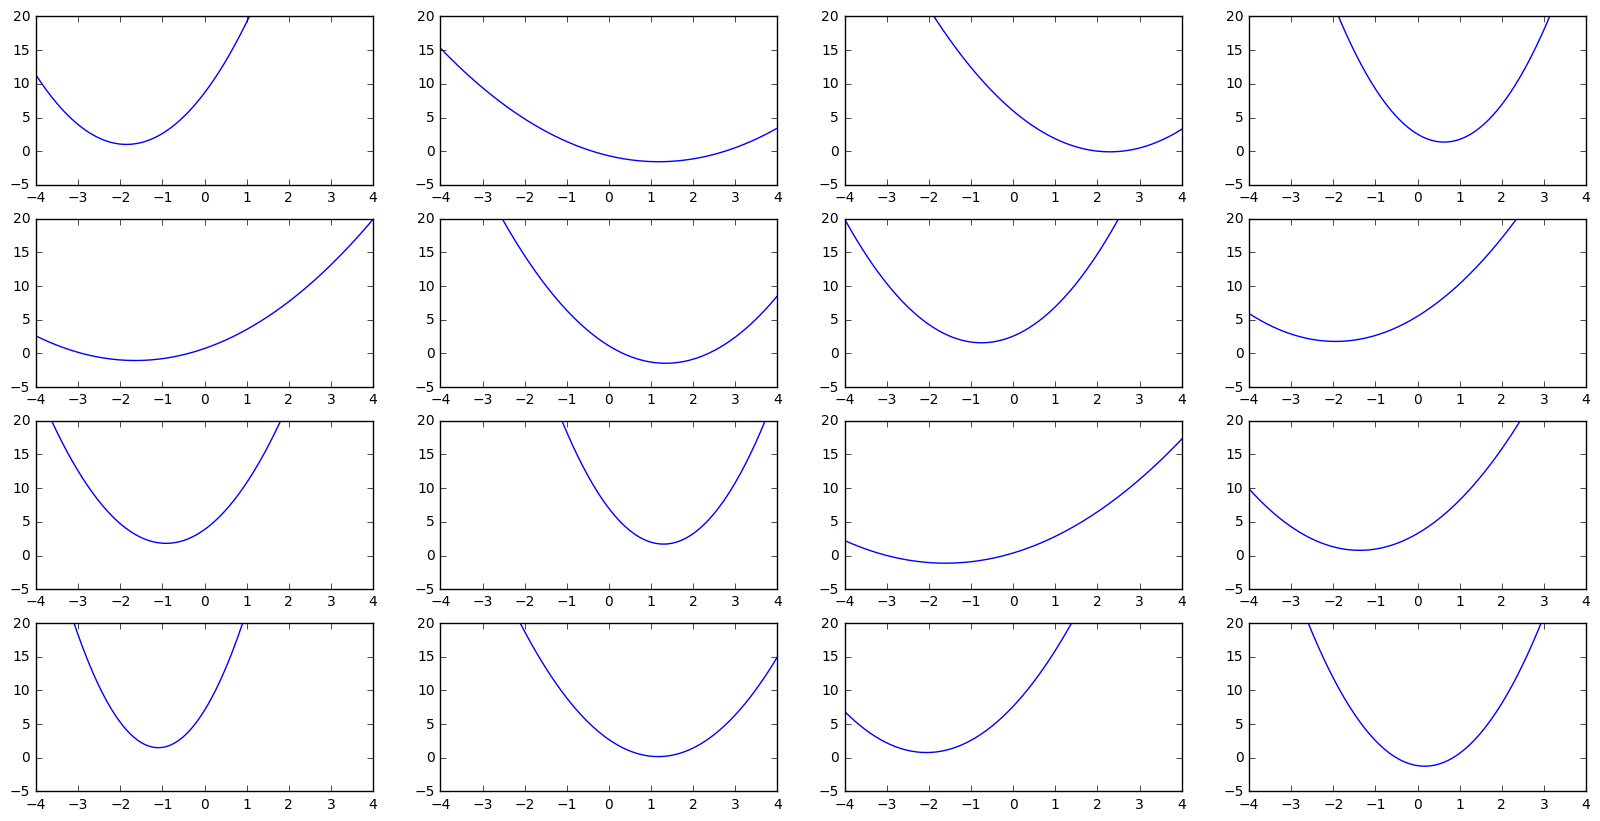

In [5]:
# visualize training data
plt.figure(figsize=(20,10))
for i in range(16):
    xx = np.linspace(-4,4,200)
    yy = poly(a_train[i],b_train[i],c_train[i],xx)
    plt.subplot(4,4,1+i)
    plt.xlim(xmin=-4,xmax=4)
    plt.ylim(ymin=-5,ymax=20)
    plt.plot(xx,yy)
plt.show()

In [20]:
def rnn_cell(x,y,h):
    with tf.variable_scope('rnn_cell', reuse=True):
        W_1 = tf.Variable(tf.truncated_normal([2+n_hidden,60],stddev=0.5))
        b_1 = tf.Variable(tf.constant(0.1, shape=[60]))

        W_2 = tf.Variable(tf.truncated_normal([60,60],stddev=0.5))
        b_2 = tf.Variable(tf.constant(0.1, shape=[60]))

        W_3 = tf.Variable(tf.truncated_normal([60,1+n_hidden],stddev=0.5))
        b_3 = tf.Variable(tf.constant(0.1, shape=[1+n_hidden]))

        z = tf.concat(1,[x, y, h])

        h_1 = tf.tanh(tf.matmul(z, W_1) + b_1)
        h_2 = tf.tanh(tf.matmul(h_1, W_2) + b_2)
        out = tf.tanh(tf.matmul(h_2, W_3) + b_3)

        x_out, h_out = tf.split_v(value = out,size_splits=[1, n_hidden],split_dim=1)
    
    return x_out, h_out

In [6]:
# Create Model
seq_length = 8

a = tf.placeholder(tf.float32, [None, 1])
b = tf.placeholder(tf.float32, [None, 1])
c = tf.placeholder(tf.float32, [None, 1])

x_0 = tf.placeholder(tf.float32, shape=[None,1])
h_0 = tf.placeholder(tf.float32, [None, n_hidden])

sample_points = [x_0]

f = poly(a,b,c,x_0)
x, h = rnn_cell(x_0,f, h_0) 
f = poly(a,b,c,x)
sample_points += [x]

f_sum = tf.reduce_sum(f)/(seq_length)

for i in range(seq_length-1):
    x, h = rnn_cell(x, f, h) 
    f = poly(a,b,c,x)
    sample_points += [x]

    f_sum += tf.reduce_sum(f)/(seq_length)

In [7]:
train_step = tf.train.AdamOptimizer(0.001).minimize(f_sum)
#train_step = tf.train.GradientDescentOptimizer(1.0).minimize(f_out)

[<tf.Tensor 'gradients/rnn_cell_7/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_6/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_5/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_4/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_3/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_2/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell_1/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]
[<tf.Tensor 'gradients/rnn_cell/split_v_grad/concat:0' shape=(?, ?) dtype=float32>, None, None]


In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [9]:
epochs = 5000

print("Minimum achieveable value")
print(min_poly(a_train,b_train,c_train)*seq_length)

for i in range(epochs):
    sess.run(train_step, feed_dict={a:a_train, b:b_train, c:c_train, x_0:x_init, h_0:h_init})
    cost = sess.run([f_sum], feed_dict={a:a_train, b:b_train, c:c_train, x_0:x_init, h_0:h_init})
    if i% 500 == 0:
        print("Epoch: "+str(i)+" Minimum function value "+str(cost))
    

Minimum achieveable value
-54.0480901675
Epoch: 0 Minimum function value [1208.6547]
Epoch: 500 Minimum function value [450.75354]
Epoch: 1000 Minimum function value [429.14322]
Epoch: 1500 Minimum function value [444.43805]
Epoch: 2000 Minimum function value [409.64258]
Epoch: 2500 Minimum function value [430.75714]
Epoch: 3000 Minimum function value [441.20621]
Epoch: 3500 Minimum function value [443.25098]
Epoch: 4000 Minimum function value [401.3963]
Epoch: 4500 Minimum function value [434.08972]


## Evaluate Training Performance

In [10]:
# Generate Test Data
a_train_eval = a_train[1].reshape(-1,1)
b_train_eval = b_train[1].reshape(-1,1)
c_train_eval = c_train[1].reshape(-1,1)

x_init_eval = x_init[1].reshape(-1,1)
h_init_eval = h_init[1].reshape(-1,n_hidden)

In [11]:
samp = sess.run([sample_points], feed_dict={a:a_train_eval, b:b_train_eval, c:c_train_eval, x_0:x_init_eval, h_0:h_init_eval})

In [12]:
xx = np.linspace(-4,4,200)
yy = poly(a_train_eval,b_train_eval,c_train_eval,xx).flatten()

x_samples = np.array([float(x) for x in samp[0]])
y_samples = poly(a_train_eval,b_train_eval,c_train_eval,x_samples).flatten()
annotation = np.linspace(0,seq_length,seq_length+1)

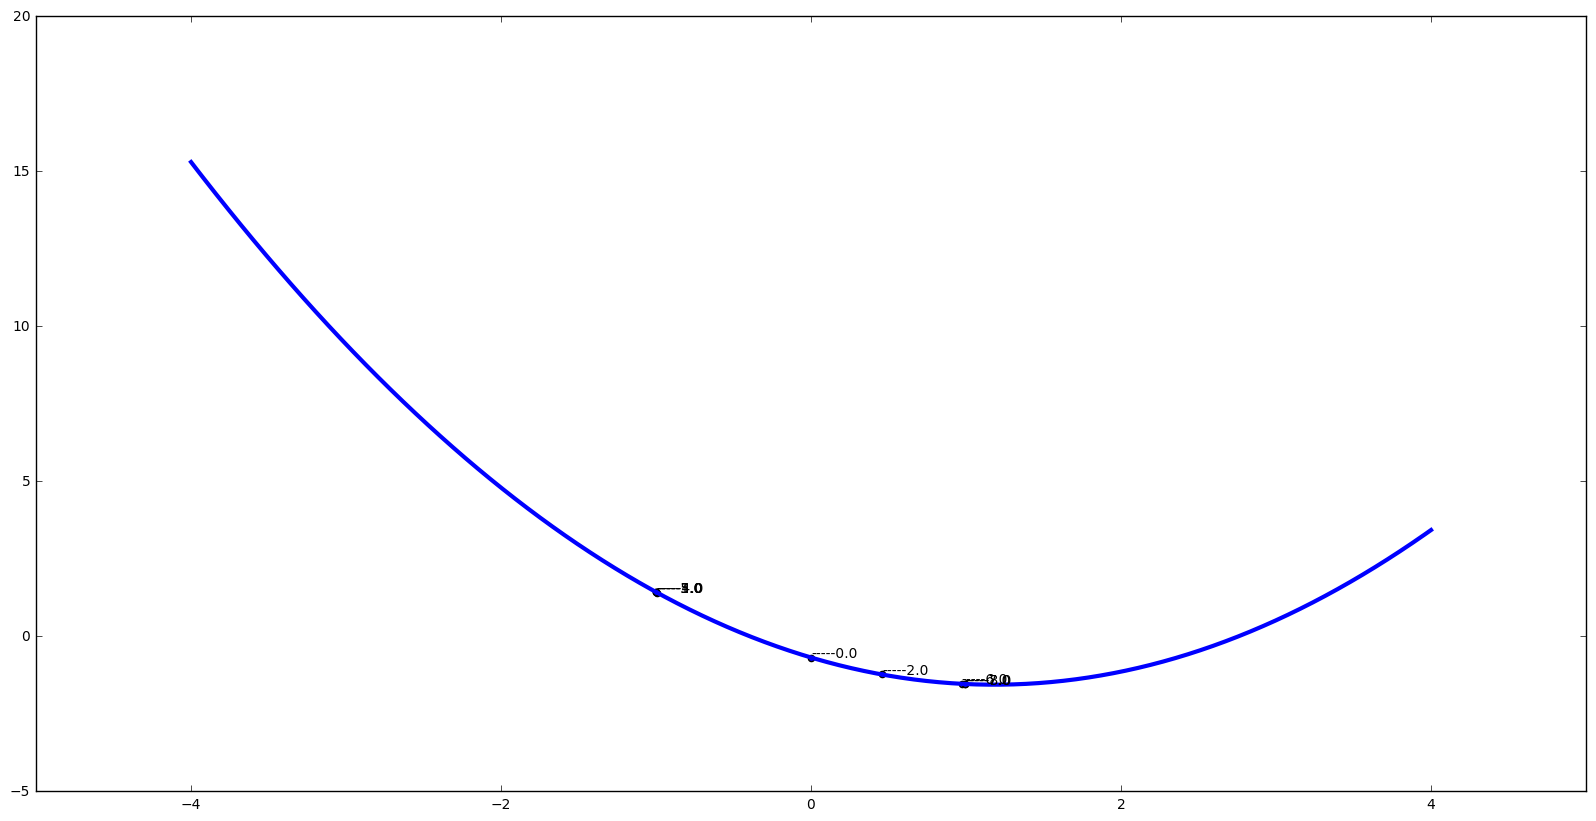

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
plt.hold(True)
ax.plot(xx,yy,linewidth=3)
ax.scatter(x_samples,y_samples)
for i, txt in enumerate(annotation):
    ax.annotate("-----"+str(txt), (x_samples[i],y_samples[i]))
plt.show()

## Evalutate Test performance

In [16]:
# Generate Test Data
n_test = 1

a_test = np.random.uniform(size=(n_test,1),low = 0.5, high = 5.0)
b_test = np.random.uniform(size=(n_test,1),low = -3.0, high = 3.0)
c_test = np.random.uniform(size=(n_test,1),low = -2.0, high = 2.0)

x_init_test = np.zeros((n_test,1))
h_init_test = np.zeros((n_test,n_hidden))

In [17]:
samp = sess.run([sample_points], feed_dict={a:a_test, b:b_test, c:c_test, x_0:x_init_test, h_0:h_init_test})

In [18]:
xx = np.linspace(-4,4,200)
yy = poly(a_test,b_test,c_test,xx).flatten()

x_samples = np.array([float(x) for x in samp[0]])
y_samples = poly(a_test,b_test,c_test,x_samples).flatten()
annotation = np.linspace(0,seq_length,seq_length+1)

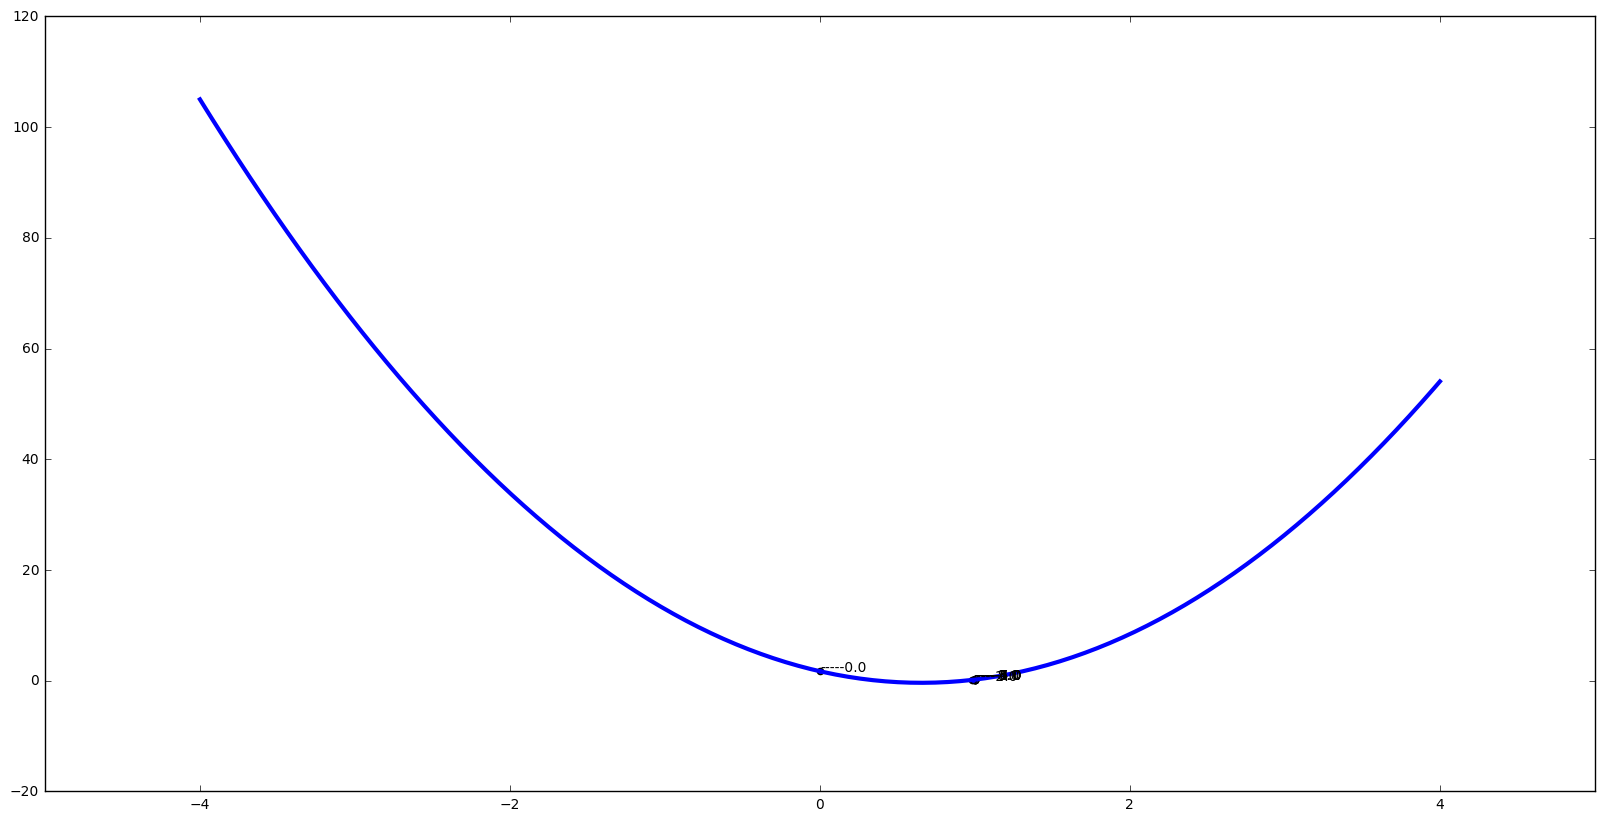

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
plt.hold(True)
ax.plot(xx,yy,linewidth=3)
ax.scatter(x_samples,y_samples)
for i, txt in enumerate(annotation):
    ax.annotate("-----"+str(txt), (x_samples[i],y_samples[i]))
plt.show()
